# Object Detection with SSD
### Here we demostrate detection on example images using SSD with PyTorch

In [1]:
import torch.nn as nn
from torch.autograd import Variable
from box_utils import*
import torch.utils.data as data
import torchvision.transforms as transforms
from torch.utils.serialization import load_lua
import PIL
from PIL import Image
from ssd import build_ssd
# from models import build_ssd as build_ssd_v1 # uncomment for older pool6 model
import torch.backends.cudnn as cudnn

## Build SSD300 in Test Phase
1. Build the architecture, specifyingsize of the input image (300),
    and number of object classes to score (21 for VOC dataset)
2. Next we load pretrained weights on the VOC 2007 dataset  

In [2]:
net = build_ssd('test', 300, 21)    # initialize SSD
net.load_weights('weights/ssd_300_VOC0712.pth')

Loading weights into state dict...
Finished!


## Load Image 
### Here we just load a sample image from the VOC07 dataset 

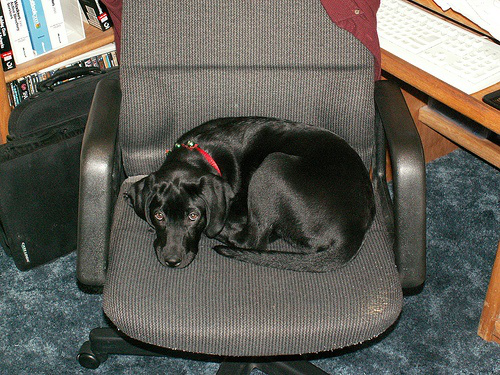

In [3]:
# image = Image.open('./data/example.jpg').convert('RGB')   # uncomment if dataset not downloaded

from data import VOCDetection, VOCroot, base_transform, detection_collate
valset = VOCDetection(VOCroot, 'val', None, None)
img_id = 16
image = valset.pull_image(img_id)
# View the sampled input image before transform
image

## Pre-process the input.  
#### Using the torchvision package, we can create a Compose of multiple built-in transorm ops to apply 
For SSD, at test time we perform the following

In [4]:
from data import SwapChannel
base_transform = transforms.Compose([
        transforms.Scale(net.size),                    # scale to 300 for SSD300
        transforms.CenterCrop(net.size),                    # crop to a square
        transforms.ToTensor(),              
        transforms.Lambda(lambda x: x.mul(255)),       # custom lambda to scale pix by 255
        SwapChannel((2, 1, 0)),                             # custom swap color channels op
        transforms.Normalize((104,117,123), (1, 1, 1)) # subtract VOC dataset means
    ])
x = base_transform(image)

## SSD Forward Pass
### Now just wrap the image in a Variable so it is recognized by PyTorch autograd

In [5]:
x = Variable(x.unsqueeze_(0))     # wrap tensorin Variable
y = net(x)                        # forward pass 

## Parse the Detections
Filter outputs with confidence scores lower than a threshold 
Here we choose 60% 

In [6]:
from data import VOC_CLASSES as labelmap
import numpy as np
top_k=10
def get_labelname(labelmap, top_label_indices):
    return [labelmap[int(l)-1] for l in top_label_indices]

detections = y.data.numpy()
# Parse the outputs.
det_label = detections[0,:top_k,1]
det_conf = detections[0,:top_k,2]
det_xmin = detections[0,:top_k,3]
det_ymin = detections[0,:top_k,4]
det_xmax = detections[0,:top_k,5]
det_ymax = detections[0,:top_k,6]

# Get detections with confidence higher than 0.6.
top_indices = [det_conf>0.6]
top_conf = det_conf[top_indices]
top_label_indices = det_label[top_indices]
top_labels = get_labelname(labelmap, top_label_indices)
top_xmin = det_xmin[top_indices]
top_ymin = det_ymin[top_indices]
top_xmax = det_xmax[top_indices]
top_ymax = det_ymax[top_indices]

## View Results 

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
plt.imshow(image)  # plot the image for matpltlib
currentAxis = plt.gca()
# scale each detection back up to the image
for i in range(top_conf.shape[0]):
    xmin = int(round(top_xmin[i] * image.size[0]))
    ymin = int(round(top_ymin[i] * image.size[1]))
    xmax = int(round(top_xmax[i] * image.size[0]))
    ymax = int(round(top_ymax[i] * image.size[1]))
    score = top_conf[i]
    label = int(top_label_indices[i])
    label_name = top_labels[i]
    display_txt = '%s: %.2f'%(label_name, score)
    coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
    color = colors[label]
    currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
    currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.5})

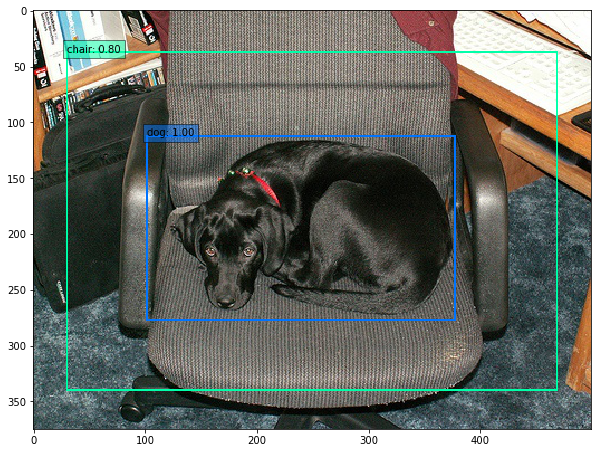

In [8]:
plt.show()  # display label, score, and bounding boxes!